
Kalman Filter in the Finance
================


Igor Marfin < <igor.marfin@unister.de>>


Abstract
----------------




--------------------------

Here are a few examples of Kalman Filters given to illustrate the prediction mechanism of the Kalman Filtering.



Motivation
-----

------------------------------

As motivation of this tutorial, let me, to quote  *Michael Halls-Moore* from **QuantStart.com**, who, in  
his presenation [AN INTRODUCTION TO BACKTESTING WITH PYTHON AND PANDAS ](https://s3.amazonaws.com/quantstart/media/powerpoint/an-introduction-to-backtesting.pdf), has summarized key points of  **QUANTITATIVE TRADING**:

>* Identification statistically signiﬁcant and repeatable market behaviour that can be exploited to generate proﬁts
     * Forecasting methods attempt to predict the direction or value of an instrument in subsequent future time periods based on certain historical factors. 

Therefore, today, I will focus on **Forecasting** of the values of instruments (stocks prices), which
plays the significant role in the quantitative trading.



Initialization 
--------------------------

________


In [1]:
import sys
sys.path = ['/usr/local/lib/python2.7/dist-packages'] + sys.path # to fix the problem with numpy: this replaces  1.6 version by 1.9

%matplotlib inline
%pylab inline


import os
import matplotlib 
import numpy as np
import matplotlib.pyplot as pl
import matplotlib as mpl
import logging
import pymc as pm

# a plotter and dataframe modules
import seaborn as  sns # seaborn to make a nice plots of the data
import pandas as pd
import scipy.stats as stats

# use a nice style for plots and the notebook

import json
s = json.load( open("styles/my_matplotlibrc.json") )
matplotlib.rcParams.update(s)

from IPython.core.display import HTML
from IPython.display import display, Math, Latex
import urllib2


def css_styling():
    styles = open("styles/custom_v3.css", "r").read()
    return HTML(styles)
css_styling()

#HTML( urllib2.urlopen('http://bit.ly/1Bf5Hft').read() )

ion()


# Set up logging.
logger = logging.getLogger()
logger.setLevel(logging.INFO)

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:855: UserWarning: svg.embed_char_paths is deprecated and replaced with svg.fonttype; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


Stock Prices
-----------------

-----------------------


For this exercise, we will be examining the daily **'closed'** prices of the GOOG (google). 



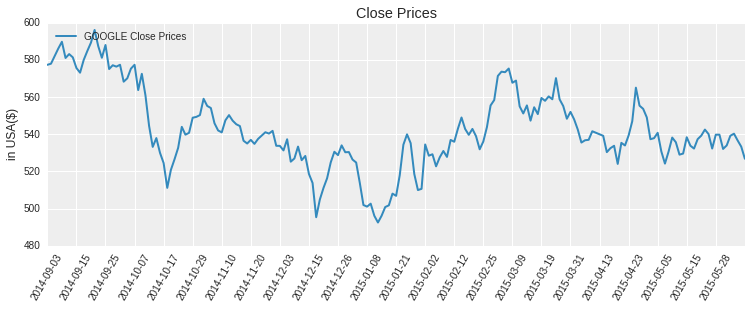

In [3]:
import datetime
import ystockquote as ysq

stocks = [ "GOOG"]

enddate = datetime.datetime.now().strftime("%Y-%m-%d")  # today's date.
startdate = "2014-09-01"
#startdate = "2015-06-05"

stock_closes = {}


import operator

for stock in stocks:

    data=np.array(sorted(ysq.get_historical_prices(stock, startdate, enddate).items(),key=operator.itemgetter(0)))    
    x = data[:,1,None]
    stock_closes[stock] = np.apply_along_axis(lambda x:float(x[0]['Close']),1,x)                                  
    n_observations = len(stock_closes[stock])

dates = map(lambda x: datetime.datetime.strptime(x, "%Y-%m-%d"), data[:,0][1:n_observations + 1])    


figsize(12.5, 4)


plt.xticks(np.arange(n_observations)[::8],
           map(lambda x: datetime.datetime.strftime(x, "%Y-%m-%d"), dates[::8]),
           rotation=60);

plt.plot(stock_closes['GOOG'],label='GOOGLE Close Prices')

plt.legend(loc="upper left")
plt.title("Close Prices")
plt.ylabel("in USA($)");
pl.savefig('plots/google_prices.png')



Realization of the **Kalman Filtering model** (Part 1)
-----------------

----------------

In this part we will develop the kalman filter for the time series of the stock price *GOOG*.


We will follow the prescription given  in the wiki [about Kalman Filter application](http://en.wikipedia.org/wiki/Kalman_filter#Example_application.2C_technical).

First, we introduce the model as follows

> Consider a price as a truck on frictionless, straight rails.  Initially the price is stationary at some position (say, **stock_closes['GOOG'].mean()** ), but it is buffeted this way and that by random uncontrolled forces. 

We measure the position of the price every Δt days, but these measurements are imprecise; we want to maintain a model of where the price is and what its velocity is. We show here how we derive the model from which we create our Kalman filter.

>The position and velocity of the price are described by the linear state space

$$\mathbf{x}_{k} = \begin{bmatrix} x_k \\ \dot{x}_k \end{bmatrix} $$

where $\dot{x}_k$ is the velocity, that is, the derivative of price with respect to time.

We assume that between the $(k − 1)$ and $k$ timestep uncontrolled forces cause a constant acceleration of $a_k$ that is normally distributed, with mean 0 and standard deviation $\sigma_a$. 

Let's asume that the analogue of  Newton's laws of motion can be applied


$$\mathbf{x}_{k} = \mathbf{F} \mathbf{x}_{k-1} + \mathbf{G}a_{k}.$$

We assume that $a_k$ is the effect of an unknown input and $\mathbf{G}$ applies that effect to the state vector. Here

$$\mathbf{F} = \begin{bmatrix} 1 & \Delta t \\ 0 & 1 \end{bmatrix}$$

and

$$\mathbf{G} = \begin{bmatrix} \frac{\Delta t^2}{2} \\[6pt] \Delta t \end{bmatrix} $$

Thus the price state $x_k$ is defined as 

$$\mathbf{x}_{k} = \mathbf{F} \mathbf{x}_{k-1} + \mathbf{w}_{k},$$

where $$\mathbf{w}_{k} \sim N(0, \mathbf{Q})$$ and

$$\mathbf{Q}=\mathbf{G}\mathbf{G}^{\text{T}}\sigma_a^2 =\begin{bmatrix} \frac{\Delta t^4}{4} & \frac{\Delta t^3}{2} \\[6pt] \frac{\Delta t^3}{2} & \Delta t^2 \end{bmatrix}\sigma_a^2.$$


At each time step, a noisy measurement of the true position of the price is made. Let us suppose the measurement noise $v_k$ is also normally distributed, with mean 0 and standard deviation $\sigma_v$:

$$\mathbf{z}_{k} = \mathbf{H x}_{k} + \mathbf{v}_{k},$$

where $H$ is the transformation matrix (telling us that we measure only the price but not the velocity)

$$\mathbf{H} = \begin{bmatrix} 1 & 0 \end{bmatrix}, $$

and

$$\mathbf{R} = \textrm{E}[\mathbf{v}_k \mathbf{v}_k^{\text{T}}] = \begin{bmatrix} \sigma_v^2 \end{bmatrix}.$$

The KalmanFilter class defines our model.

In [4]:
class BasicKalmanFilter(object):
    ''' Stochastic Kalman Filter to model 'Close' prices of the stock market '''

    def __init__(self, data,  F_init, G_init, H_init, P_init, x_init,acc_variance=100., obs_variance=100., delta_t = 0.5):
        
        # Specify the model.
        logging.info('building the KalmanFilter model')
        
        # data to be tested
        self.data = data 
        
        # a state transition model: it's stable and doesn't depend on x_k
        self.F = F_init
        
        #  Effect from unknown forces a_k 
        self.G = G_init
        
        #  x is our state vector
        self.x = x_init
        
        #  acc_variance is variance of the unknown forces a_k 
        self.acc_variance = acc_variance
        
        
        #  obs_variance is variance of the measurement of the 'close' price
        self.obs_variance = obs_variance
        
        
        # delta_t is the typical period of the action of the force during the trading day: 
        # delta_t = 0.5 -> means that the force acts on the price during the first half of the trading day.
        self.delta_t = delta_t
        
        
        # a dim. of the hidden state
        self.dim = x_init.shape[0]
        
        
        # a control input: this Kalman Filter is designed w/o use of the control input
        self.B = np.zeros((self.dim,self.dim))
        self.u = np.zeros((self.dim,1))

        # the Q matrix: the covariance matrix of the  state transition model, i.e Q=G^T.G*\sigma_a^2
        # explicitelly , it is 
        #self.Q = np.array([ [self.delta_t**4/4, self.delta_t**3/2], [self.delta_t**3/2, self.delta_t**2]])*self.acc_variance
        self.Q = self.G.T*self.G*self.acc_variance
        
        
        # the H matrix: the observation model 
        self.H = H_init
        
        # Predicted (a priori) estimate covariance
        self.P = P_init
        
        
        # the matrix R is the  covariance of measurement
        self.R = np.array( [[ self.obs_variance]])
        
        logging.info('done building the KalmanFilter model') 
        
    
    def predict(self):
        raise NotImplementedError(
            'KalmanFilter prediction is not implemented ')
    
    def update(self,z):
        raise NotImplementedError(
            'KalmanFilter update is not implemented ')    

    def __str__(self):
        return self.__class__.__name__

I have called this section as 'Part 1' because, we want to test the Kalman Filter on timeseries.

In [5]:
# Kalman Filter of the stochastic price process as a function of the time
class KalmanFilter(BasicKalmanFilter):
    pass

In [6]:
# Test of Kalaman Filter Class


# a transition model: We measure the state each day -> delta_t = 1.
delta_t = 1.
F_init = np.array([[1, delta_t],[0,1]])

# an 'acting-force' model
G_init =  np.array([[delta_t**2/2], [delta_t]])

# an observation model
H_init = np.array([[1,0]])

# an initial state: the price and its velocity
x_init   = np.array([[stock_closes['GOOG'][-100]],[0.]])



# a priory covariance matrix
# If the initial price and velocity are not known perfectly 
# the covariance matrix should be initialized with a suitably large number, say L, on its diagonal.

P_init = np.array([[1, 0],[0,100.]]) # L=100.

    
kf = KalmanFilter(stock_closes['GOOG'][-100:],F_init,G_init,H_init,P_init,x_init,acc_variance=100., obs_variance=100.,delta_t = delta_t)
?kf




INFO:root:building the KalmanFilter model
INFO:root:done building the KalmanFilter model


Let's add predict/update support to our model.

In [7]:
from numpy.linalg import inv
def _predict(kalman_model):
    ''' predicts the price  using kalman_model '''
    
    # the state vector should be of the one-column type
    assert kalman_model.x.shape[1] == 1
    
    # check the consistency of the transition model
    assert kalman_model.F.shape[0] == kalman_model.x.shape[0]
    
    # check the consistency of the control-input model
    assert kalman_model.u.shape == kalman_model.x.shape        
    assert kalman_model.B.shape[0] == kalman_model.u.shape[0]
    
    # check the consistency of the control-input model
    assert kalman_model.F.shape[1] == kalman_model.P.shape[0]
    assert kalman_model.Q.shape == kalman_model.P.shape

    x_p = np.dot(kalman_model.F, kalman_model.x) + np.dot(kalman_model.B,kalman_model.u)
    P_p = np.dot(kalman_model.F,kalman_model.P).dot(kalman_model.F.T) + kalman_model.Q

    assert kalman_model.x.shape == x_p.shape
    assert P_p.shape == kalman_model.P.shape

    return x_p, P_p



def _update(kalman_model,z):
    ''' updates the price  using kalman_model '''
    
    # make a prediction
    x_p, P_p = kalman_model.predict()
    
    assert kalman_model.H.shape[1] == x_p.shape[0]
    assert kalman_model.H.shape[1] == P_p.shape[0]
    assert kalman_model.R.shape[0] == kalman_model.H.shape[0]
    
    # check the consistency of the measured data
    assert z.shape[1] == 1
    assert z.shape[0] == kalman_model.H.shape[0]

    y = z - dot(kalman_model.H,x_p)
    S = np.dot(kalman_model.H,P_p).dot(kalman_model.H.T) + kalman_model.R
    K = np.dot(P_p, kalman_model.H.T).dot(inv(S))
    x_u = x_p + np.dot(K,y)
    P_u = (np.eye(K.shape[0]) - np.dot(K,kalman_model.H)).dot(P_p)

    # save updated parametes of the model
    kalman_model.x = x_u
    kalman_model.P = P_u
    return x_u, P_u

# Update our class with the predict/update infrastructure
KalmanFilter.predict = _predict
KalmanFilter.update = _update

In [77]:
# predict and update the first two data inputs:

# timestamp 0
x_p, P_p = kf.predict()
print '0: price_pred=',x_p
print '0: Cov_Mat:', kf.P
print '0: Cov_Mat_pred=',P_p


# timestamp 0
x_u, P_u = kf.update(np.array([[stock_closes['GOOG'][-100]]]))
print '0: price_update=',x_u
print '0: Cov_Mat_update=',P_u


0: price_pred= [[ 496.18225]
 [   0.     ]]
0: Cov_Mat: [[   1.    0.]
 [   0.  100.]]
0: Cov_Mat_pred= [[ 126.  150.]
 [ 150.  200.]]
(1, 1)
0: price_update= [[ 496.18225]
 [   0.     ]]
0: Cov_Mat_update= [[  55.75221239   66.37168142]
 [  66.37168142  100.44247788]]


In [78]:
# timestamp 1
x_p, P_p = kf.predict()
print '1: price_pred=',x_p
print '1: Cov_Mat:', kf.P
print '1: Cov_Mat_pred=',P_p

# timestamp 1
x_u, P_u = kf.update(np.array([[stock_closes['GOOG'][-99]]]))
print '1: price_update=',x_u
print '1: Cov_Mat_update=',P_u


1: price_pred= [[ 496.18225]
 [   0.     ]]
1: Cov_Mat: [[  55.75221239   66.37168142]
 [  66.37168142  100.44247788]]
1: Cov_Mat_pred= [[ 313.9380531   216.81415929]
 [ 216.81415929  200.44247788]]
1: price_update= [[ 499.73924539]
 [   2.45655778]]
1: Cov_Mat_update= [[ 75.84179583  52.37840727]
 [ 52.37840727  86.87867451]]


Now, let's try our KalmanFilter on the whole dataseries.

In [8]:
def _draw_predicted(kalman_model,xticks=None,steps_jump = 8):
    ''' draws predicted prices '''
    
    time_steps = len(kalman_model.data)
    price_guesses = np.zeros((2,time_steps))
    price_predicted = np.zeros((2,time_steps))
    price_actual = np.zeros((2,time_steps))
    
    covariance_matrix = np.zeros(time_steps)
    
    for i in range(time_steps):
        x_p, P_p = kalman_model.predict()
        x_g, P_g = kalman_model.update(np.array([[kalman_model.data[i]]]))
    
        
        price_guesses[:,i] = x_g[:,0]
        covariance_matrix[i] = P_p[0][0]
        price_predicted[:,i] = x_p[:,0]
        price_actual[:,i] = np.array([[kalman_model.data[i]],[0.]])[:,0] # Here 0. --> observed velocity :-)
    
    guesses, actual,predicted,std = price_guesses[0,2:], price_actual[0,2:], price_predicted[0,2:],covariance_matrix[2:]
    plt.plot(actual, label='actual')
    plt.plot(guesses, label='guesses')
    plt.plot(predicted, label='predicted')

    std = np.sqrt(std)
    
    plt.plot(predicted+std, c='k', ls=':', lw=2,label='68% CL')
    plt.plot(predicted-std, c='k', ls=':', lw=2)
    plt.fill_between(range(len(predicted)), predicted+std, predicted-std,
                     facecolor='yellow', alpha=0.2,label='68% CL')
    

    if (xticks is not None):
        plt.xticks(np.arange(time_steps)[::steps_jump], 
           xticks,
           rotation=60)


    plt.legend(loc="upper left")
    plt.title("Close Prices")
    plt.ylabel("in USA($)");


# update the KalmanFilter class definition
KalmanFilter.draw_predicted = _draw_predicted

You can test different initilal prices of the model.  They initial point doesn't  make an influence on the 
convergence.

INFO:root:building the KalmanFilter model
INFO:root:done building the KalmanFilter model


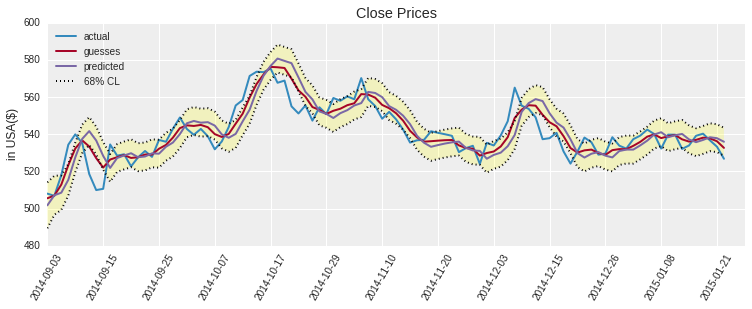

In [9]:
# it seems that it doesn't depend much on the initial conditions
#P_init = np.array([[10000, 0],[0,10000.]]) # L=10000.


# Here the true init values for a price is used
kf = KalmanFilter(stock_closes['GOOG'][-100:],F_init,G_init,H_init,P_init,x_init,acc_variance=1., obs_variance=100.,delta_t =delta_t)

# If we don't know the initial price, assume it is zero
#kf = KalmanFilter(stock_closes['GOOG'][-100:],F_init,G_init,H_init,P_init,np.zeros((2,1)),acc_variance=10000., obs_variance=10000.,delta_t = 200*100)

steps_jump = 8
xticks = map(lambda x: datetime.datetime.strftime(x, "%Y-%m-%d"), dates[::steps_jump])
kf.draw_predicted(xticks,steps_jump)

Please, you can play with the covariance matrix of the  state transition model 'acc_variance' and 
the covariant matrix of the observation model 'obs_variance' to see the change of the error band on the predicted price. Also, it is interesting to plot the convergence of the hidden state $x_k$, the convergence is
charachterized by *'cov[0,0]'*:

INFO:root:building the KalmanFilter model
INFO:root:done building the KalmanFilter model
/usr/local/lib/python2.7/dist-packages/matplotlib/axes/_axes.py:475: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


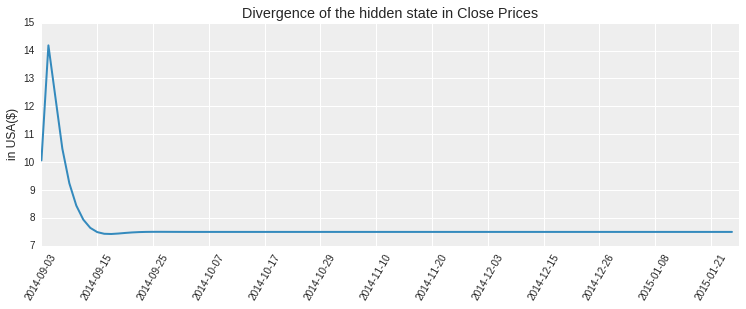

In [10]:
def _draw_cov(kalman_model,xticks=None,steps_jump = 8):
    ''' draws predicted prices '''
    
    time_steps = len(kalman_model.data)
    covariance_matrix = np.zeros(time_steps)
    
    for i in range(time_steps):
        x_p, P_p = kalman_model.predict()
        x_g, P_g = kalman_model.update(np.array([[kalman_model.data[i]]]))
    
        covariance_matrix[i] = P_p[0][0]
    
    
    
    covariance_matrix = np.sqrt(covariance_matrix)
    
    plt.plot(covariance_matrix)
    

    if (xticks is not None):
        plt.xticks(np.arange(time_steps)[::steps_jump], 
           xticks,
           rotation=60)


    plt.legend(loc="upper left")
    plt.title("Divergence of the hidden state in Close Prices")
    plt.ylabel("in USA($)");


# update the KalmanFilter class definition
KalmanFilter.draw_cov = _draw_cov


kf = KalmanFilter(stock_closes['GOOG'][-100:],F_init,G_init,H_init,P_init,np.array([[1e-9],[0.]]),acc_variance=1., obs_variance=100.,delta_t =delta_t)
steps_jump = 8
xticks = map(lambda x: datetime.datetime.strftime(x, "%Y-%m-%d"), dates[::steps_jump])
kf.draw_cov(xticks,steps_jump)

It would be nice to introduce the metric which would give us the quality of the KalmanFilter. Such metric is
MASE: ** *MEAN-ABSOLUTE SCALED ERROR*   **

In [11]:
# Here we introduce the metric we want to test

def MASE(training_series, testing_series, prediction_series):
    """
    Computes the MEAN-ABSOLUTE SCALED ERROR forcast error for univariate time series prediction.
    
    See "Another look at measures of forecast accuracy", Rob J Hyndman
    
    parameters:
        training_series: the series used to train the model, 1d numpy array
        testing_series: the test series to predict, 1d numpy array or float
        prediction_series: the prediction of testing_series, 1d numpy array (same size as testing_series) or float
        absolute: "squares" to use sum of squares and root the result, "absolute" to use absolute values.
    
    """
    
    n = training_series.shape[0]
    d = np.abs(  np.diff( training_series) ).sum()/(n-1)
    
    errors = np.abs(testing_series - prediction_series )
    #errors = testing_series - prediction_series 
    return errors.mean()/d,errors

INFO:root:building the KalmanFilter model
INFO:root:done building the KalmanFilter model


MASE= 0.301857667028
MAX MASE= 8.20829914693   11
MIN MASE= 0.0   0
MEAN MASE= 1.6659319441


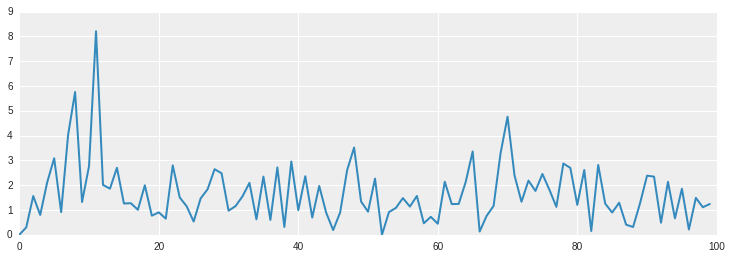

In [12]:
# Check the metric with our model
kf = KalmanFilter(stock_closes['GOOG'][-100:],F_init,G_init,H_init,P_init,x_init,acc_variance=10000., obs_variance=10000.,delta_t = 200*100)

time_steps = len(kf.data)
price_guesses = np.zeros((2,time_steps))
price_actual = np.zeros((2,time_steps))
    
for i in range(time_steps):
        x_g, P_g = kf.update(np.array([[kf.data[i]]]))
    
        price_guesses[:,i] = x_g[:,0]
        price_actual[:,i] = np.array([[kf.data[i]],[0.]])[:,0] # Here 0. --> observed velocity :-)
    
guesses, actual = price_guesses[0,:], price_actual[0,:]
print "MASE=",MASE(actual,actual,guesses)[0]
print 'MAX MASE=',np.max(MASE(actual,actual,guesses)[1]),' ',np.argmax(MASE(actual,actual,guesses)[1])
print 'MIN MASE=',np.min(MASE(actual,actual,guesses)[1]),' ',np.argmin(MASE(actual,actual,guesses)[1])
print 'MEAN MASE=',MASE(actual,actual,guesses)[1].mean()
plot(MASE(actual,actual,guesses)[1])

OK. It looks like we do in the right direction. We can try to simplify the transition model of the Kalman Filter removing the velocity of the price, and test again.

In [13]:
# Kalman Filter of the stochastic price process as a function of the time
class KalmanFilterSimplified(BasicKalmanFilter):
    pass


# Update our class with the predict/update infrastructure
KalmanFilterSimplified.predict = _predict
KalmanFilterSimplified.update = _update

In [14]:
# a transition model: We measure the state each day -> delta_t = 1.
delta_t = 1.
F_init = np.array([[1]])

# an 'acting-force' model
G_init =  np.array([[delta_t**2/2]])

# an observation model
H_init = np.array([[1]])

# an initial state: the price
x_init   = np.array([[stock_closes['GOOG'][-100]]])



# a priory covariance matrix
# If the initial price and velocity are not known perfectly 
# the covariance matrix should be initialized with a suitably large number, say L, on its diagonal.

P_init = np.array([[1]]) # 

    
kf_simple = KalmanFilterSimplified(stock_closes['GOOG'][-100:],F_init,G_init,H_init,P_init,x_init,acc_variance=100., obs_variance=100.,delta_t = delta_t)
?kf_simple


INFO:root:building the KalmanFilter model
INFO:root:done building the KalmanFilter model


If we use the same covariance of the transition model,  i.e `acc_variance=1.`,  the KF will do the bad job.
It's clear from the plot belows:

INFO:root:building the KalmanFilter model
INFO:root:done building the KalmanFilter model


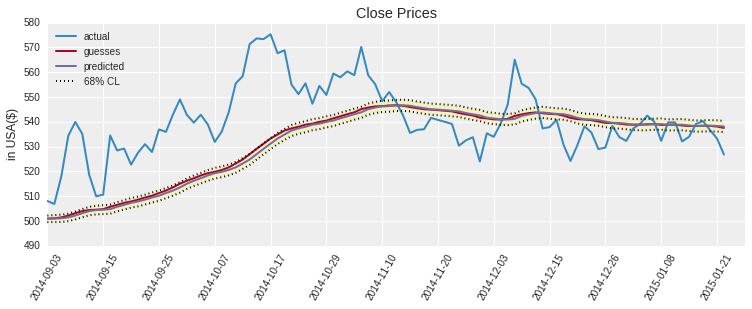

In [15]:
# predict and update the first two data inputs:
KalmanFilterSimplified.draw_predicted = _draw_predicted

# compare acc_variance=1. and acc_variance=100.

#kf_simple = KalmanFilterSimplified(stock_closes['GOOG'][-100:],F_init,G_init,H_init,P_init,x_init,acc_variance=100., obs_variance=100.,delta_t =delta_t)
kf_simple = KalmanFilterSimplified(stock_closes['GOOG'][-100:],F_init,G_init,H_init,P_init,x_init,acc_variance=1., obs_variance=100.,delta_t =delta_t)



# If we don't know the initial price, assume it is zero
#kf = KalmanFilter(stock_closes['GOOG'][-100:],F_init,G_init,H_init,P_init,np.zeros((2,1)),acc_variance=10000., obs_variance=10000.,delta_t = 200*100)

steps_jump = 8
xticks = map(lambda x: datetime.datetime.strftime(x, "%Y-%m-%d"), dates[::steps_jump])
kf_simple.draw_predicted(xticks,steps_jump)

The MASE is degreded by the factor 5.

INFO:root:building the KalmanFilter model
INFO:root:done building the KalmanFilter model


MASE= 2.48712684241
MAX MASE= 44.5013074534   32
MIN MASE= 0.0   0
MEAN MASE= 13.7262839689


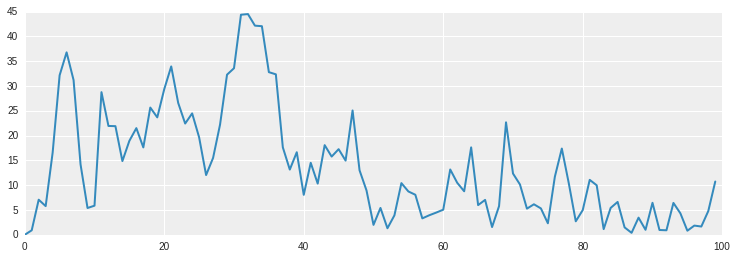

In [16]:
# Check the metric with our model
kf_simple = KalmanFilterSimplified(stock_closes['GOOG'][-100:],F_init,G_init,H_init,P_init,x_init,acc_variance=1., obs_variance=100.,delta_t =delta_t)

time_steps = len(kf_simple.data)
price_guesses = np.zeros((2,time_steps))
price_actual = np.zeros((2,time_steps))
    
for i in range(time_steps):
        x_g, P_g = kf_simple.update(np.array([[kf_simple.data[i]]]))
    
        price_guesses[:,i] = x_g[:,0]
        price_actual[:,i] = np.array([[kf_simple.data[i]],[0.]])[:,0] # Here 0. --> observed velocity :-)
    
guesses, actual = price_guesses[0,:], price_actual[0,:]
print "MASE=",MASE(actual,actual,guesses)[0]
print 'MAX MASE=',np.max(MASE(actual,actual,guesses)[1]),' ',np.argmax(MASE(actual,actual,guesses)[1])
print 'MIN MASE=',np.min(MASE(actual,actual,guesses)[1]),' ',np.argmin(MASE(actual,actual,guesses)[1])
print 'MEAN MASE=',MASE(actual,actual,guesses)[1].mean()
plot(MASE(actual,actual,guesses)[1])

INFO:root:building the KalmanFilter model
INFO:root:done building the KalmanFilter model


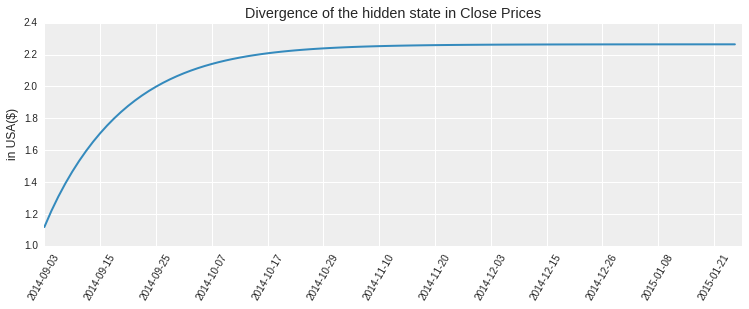

In [17]:
# update the KalmanFilter class definition
KalmanFilterSimplified.draw_cov = _draw_cov


kf_simple = KalmanFilterSimplified(stock_closes['GOOG'][-100:],F_init,G_init,H_init,P_init,x_init,acc_variance=1., obs_variance=100.,delta_t =delta_t)
steps_jump = 8
xticks = map(lambda x: datetime.datetime.strftime(x, "%Y-%m-%d"), dates[::steps_jump])
kf_simple.draw_cov(xticks,steps_jump)

Realization of the **Kalman Filtering model** (Part 2)
-----------------

----------------


Another way of the use of  the Kalman Filtering technique is the Online Linear Regression. 


Linear regression is useful for many financial applications such as finding the hedge ratio between two assests in a pair trade. In a perfect world, the realtionship between assests would remain constant along with the slope and intercet of a linear regression. Unfortutanely this is usually the exception rather than the rule. In this part, I’m going to show you how to use a Kalman filter for online linear regression that calculates the time-varying slope and intercept. 


For this example,  I use two related ETF’s, the iShares MSCI Australia (EWA) and iShares MSCI Canada (EWC). Let's plot them for the requested period.

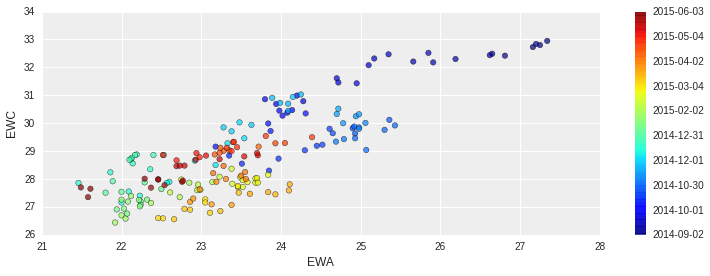

In [19]:
from pandas.io.data import DataReader 
    
stocks = [ "EWA","EWC"]
enddate = datetime.datetime.now().strftime("%Y-%m-%d")  # today's date.
startdate = "2014-09-01"
data = DataReader(stocks, 'yahoo', startdate, enddate)['Close']



# visualize the correlation between assest prices over time
cm = plt.cm.get_cmap('jet')
dates = [str(p.date()) for p in data[::len(data)//10].index]
colors = np.linspace(0.1, 1, len(data))
sc = plt.scatter(data[data.columns[0]], data[data.columns[1]], s=30, c=colors, cmap=cm, edgecolor='k', alpha=0.7)
cb = plt.colorbar(sc)
cb.ax.set_yticklabels([str(p.date()) for p in data[::len(data)//9].index]);
plt.xlabel(data.columns[0])
plt.ylabel(data.columns[1])
pl.savefig('plots/ewa_ewc_prices.png')



In [20]:
stocks = [ "EWA","EWC"]

enddate = datetime.datetime.now().strftime("%Y-%m-%d")  # today's date.
startdate = "2014-09-01"
#startdate = "2015-06-05"

stock_closes = {}


import operator

for stock in stocks:

    data=np.array(sorted(ysq.get_historical_prices(stock, startdate, enddate).items(),key=operator.itemgetter(0)))    
    x = data[:,1,None]
    stock_closes[stock] = np.apply_along_axis(lambda x:float(x[0]['Close']),1,x)                                  
    n_observations = len(stock_closes[stock])

dates = map(lambda x: datetime.datetime.strptime(x, "%Y-%m-%d"), data[:,0][1:n_observations + 1])    



What is the idea behind of application of the KF as an online Linear Regression? I will follow [this discussion](http://www.thealgoengineer.com/2014/online_linear_regression_kalman_filter/) and 
[this post](http://chairnerd.seatgeek.com/using-a-kalman-filter-to-predict-ticket-prices/) where  the topic  was investigated.

Before we continue with the Kalman filter, recall the equation for a linear regression

$$ a_k=\beta \cdot b_k+\alpha $$

where $a_k$ and $b_k$ is the closing price of EWC and EWA respectively and $\beta$ and $\alpha$ is the slope and intercept. The Kalman Model is the following:


$$\mathbf{x}_{k} = \begin{bmatrix} \beta_k \\ \alpha_k \end{bmatrix}, $$
$$\mathbf{x}_{k} = \mathbf{F} \mathbf{x}_{k-1} + \mathbf{w}_{k},$$

where $$\mathbf{w}_{k} \sim N(0, \mathbf{Q}).$$

The transition matrix $F_k$ is defined as 
$$\mathbf{F}_{k} = \begin{bmatrix} \hat{I}, \,\, \hat{I} \end{bmatrix}, $$

The observation matrix $H_k$ is also quite easy:
$$\mathbf{H}_{k} = \begin{bmatrix} price^{EWA}_k, \,\, 1 \end{bmatrix}, $$

finally, the observation $z_k$ is the price of EWC
$$\mathbf{z}_{k} = \mathbf{H x}_{k} + \mathbf{v}_{k},$$

and

$$ \mathbf{w}_{k} \sim N(0, \mathbf{R}) \\  \mathbf{R} = \textrm{E}[\mathbf{v}_k \mathbf{v}_k^{\text{T}}] = \begin{bmatrix} \sigma_v^2 \end{bmatrix}.$$


<div class=warn>
**WARNING:** Here we should understand that $\mathbf{H}_{k} $ observation matrix is not constan and 
it develops in timeseries.
<div/>

That means that we need to update $\mathbf{H}_{k} $ each time. The new Kalman Filter class for Online Linear Regression is inherited from the basic one. The only difference here is the `update` method.


In [21]:
from numpy.linalg import inv

def _update(kalman_model,z,Hk):
    ''' updates the price  using kalman_model '''
    
    # make a prediction
    x_p, P_p = kalman_model.predict()
    
    # a new feature is here
    # assign a new observation matrix Hk to the observation model 
    kalman_model.H = Hk
    
    
    assert kalman_model.H.shape[1] == x_p.shape[0]
    assert kalman_model.H.shape[1] == P_p.shape[0]
    assert kalman_model.R.shape[0] == kalman_model.H.shape[0]
    
    # check the consistency of the measured data
    assert z.shape[1] == 1
    assert z.shape[0] == kalman_model.H.shape[0]

    y = z - dot(kalman_model.H,x_p)
    S = np.dot(kalman_model.H,P_p).dot(kalman_model.H.T) + kalman_model.R
    K = np.dot(P_p, kalman_model.H.T).dot(inv(S))
    x_u = x_p + np.dot(K,y)
    P_u = (np.eye(K.shape[0]) - np.dot(K,kalman_model.H)).dot(P_p)

    # save updated parametes of the model
    kalman_model.x = x_u
    kalman_model.P = P_u
    return x_u, P_u


# Online Linear Regression of the stochastic price process as a function of the another price
class OLR(BasicKalmanFilter):
    pass


# Update our class with the predict/update infrastructure
OLR.predict = _predict
OLR.update = _update

In [24]:
# Test of OLR Class


# a transition model: delta_t is obsolete now. But it's kept for compatibility.

delta_t = 1.
F_init = np.array([[1, 0],[0,1]])

# G matrix does n't depend on delta_t
G_init =  np.array([[1], [1]])

# an observation model
H_init = np.array([[stock_closes['EWA'][-100],1]])

# an initial state: let's assume zeros for a slope and a intercept.
x_init   = np.array([[0.],[0.]])



# a priory covariance matrix
P_init = np.array([[1., 0.],[0,1.]]) 

    
olr = OLR(stock_closes['EWC'][-100:],F_init,G_init,H_init,P_init,x_init,acc_variance=100., obs_variance=100.,delta_t = delta_t)
# a hack : use the symmetric  matrix Q
olr.Q = np.array([[100, 0],[0,100]])
?olr


INFO:root:building the KalmanFilter model
INFO:root:done building the KalmanFilter model


In [316]:
# predict and update the first two data inputs in a 'manual' mode:

# timestamp 0
x_p, P_p = olr.predict()
print '0: price_pred=',x_p
print '0: Cov_Mat:', olr.P
print '0: Cov_Mat_pred=',P_p


# timestamp 0
x_u, P_u = olr.update(np.array([[stock_closes['EWC'][-100]]]), np.array([[stock_closes['EWA'][-100],1]])  )
print '0: price_update=',x_u
print '0: Cov_Mat_update=',P_u


0: price_pred= [[  2.12275636e+03]
 [  1.00000000e+09]]
0: Cov_Mat: [[  2.04883258e-01   0.00000000e+00]
 [  0.00000000e+00   3.00000000e+02]]
0: Cov_Mat_pred= [[ 100.20488326    0.        ]
 [   0.          400.        ]]
0: price_update= [[ -4.51112090e+07]
 [  9.91791962e+08]]
0: Cov_Mat_update= [[   1.02805907  -18.04449279]
 [ -18.04449279  396.71693742]]


In [317]:
# timestamp 1
x_p, P_p = olr.predict()
print '1: price_pred=',x_p
print '1: Cov_Mat:', olr.P
print '1: Cov_Mat_pred=',P_p

# timestamp 1
x_u, P_u = olr.update(np.array([[stock_closes['EWC'][-99]]]), np.array([[stock_closes['EWA'][-99],1]]) )
print '1: price_update=',x_u
print '1: Cov_Mat_update=',P_u


1: price_pred= [[ -4.51112090e+07]
 [  9.91791962e+08]]
1: Cov_Mat: [[   1.02805907  -18.04449279]
 [ -18.04449279  396.71693742]]
1: Cov_Mat_pred= [[ 101.02805907  -18.04449279]
 [ -18.04449279  496.71693742]]
1: price_update= [[ -4.49391651e+07]
 [  9.91799622e+08]]
1: Cov_Mat_update= [[   1.22342772  -22.48836161]
 [ -22.48836161  496.51907115]]


Now, let's try our new KalmanFilter on the whole dataseries. We introduce the draw function for this purpose.

In [25]:
def _draw_LR(kalman_model,Hk,slope=True,xticks=None,steps_jump = 8):
    ''' to draw the linear regression parameters over the timeseries '''
    
    time_steps = len(kalman_model.data)
    
    params_guesses = np.zeros((time_steps,2))
    params_predicted = np.zeros((time_steps,2))
    
   
    
    for i in range(time_steps):
        x_p, P_p = kalman_model.predict()
        x_g, P_g = kalman_model.update(np.array([[kalman_model.data[i]]]),  np.array([[Hk[i],1]]))
        
   
        params_guesses[i] = x_g[:,0]
        params_predicted[i] = x_p[:,0]
    
    title = 'slope'
    index =  0
    if (not slope):
        title = 'intercept'
        index =  1
    
    figsize(12.5, 4)
    plt.plot(params_guesses[2:,index], label='guess')
    plt.plot(params_predicted[2:,index], label='predicted')
        
    if (xticks is not None):
        plt.xticks(np.arange(time_steps)[::steps_jump], 
           xticks,
           rotation=60)


    plt.legend(loc="upper left")
    plt.title(title)

    

# Update our class
OLR.draw_LR = _draw_LR


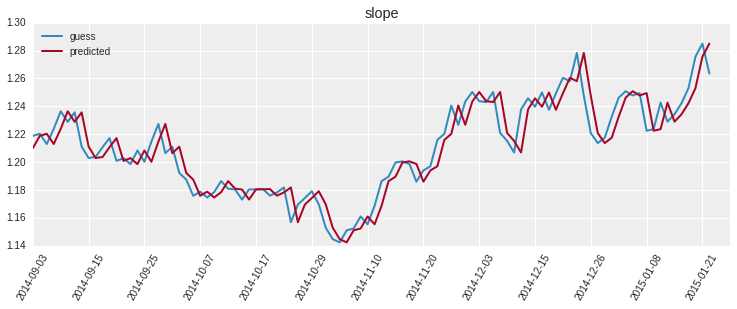

In [26]:
steps_jump = 8
xticks = map(lambda x: datetime.datetime.strftime(x, "%Y-%m-%d"), dates[::steps_jump])

olr.draw_LR(stock_closes['EWA'][-100:],True,xticks,steps_jump)

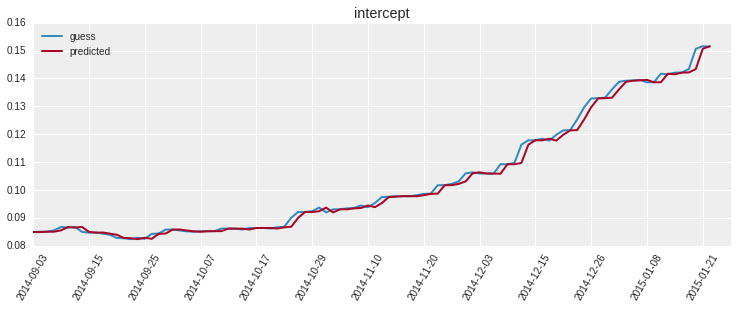

In [27]:
olr.draw_LR(stock_closes['EWA'][-100:],False,xticks,steps_jump)

You can compare the plots with results shown in this post http://nbviewer.ipython.org/github/aidoom/aidoom.github.io/blob/master/notebooks/2014-08-13-online_linear_regression_kalman_filter.ipynb

The reason of Kalman Filter in the Finance: It is an important part of the trading strategies. 
----------------------

----------------------------
    

It is time to show the simple backtesting the trading strategy on the stock market. I'm going to use the `pybacktest` to compare a KalmanFilter-based strategy with the strategy based on the Momentum or *trend following* Simple Moving Average (**SMA**)of the price. First, we need to download `pybacktest`:

In [28]:
!git clone  https://github.com/ematvey/pybacktest.git

fatal: destination path 'pybacktest' already exists and is not an empty directory.


In [42]:
sys.path = [os.getcwd()+'/pybacktest'] + sys.path 
import pybacktest

# get data: GOOG prices
ohlc = pybacktest.load_from_yahoo('GOOG',start= "2014-09-01")
ohlc.tail()



,O,H,L,C,V,AC
Date,,,,,,
2015-06-02,532.92999,543.00000,531.33002,539.17999,1934700,539.17999
2015-06-03,539.90997,543.50000,537.10999,540.31000,1714500,540.31000
2015-06-04,537.76001,540.59003,534.32001,536.70001,1335600,536.70001
2015-06-05,536.34998,537.20001,532.52002,533.33002,1375000,533.33002
2015-06-08,533.31000,534.12000,526.23999,526.83002,1520600,526.83002


Now time to define strategy. To do so, all we need to do is to create binary Series with signals, and, optionally, trade price Series with float elements.
The strategy based on the KF will be the following:

 * The short position (buy) is 
   * opened, when the price crosses the 'predicted price' up
   * closed, when the price crosses the  'predicted price' down
 * The long position (sell) is 
   * opened, when the price crosses the 'predicted price' down
   * closed, when the price crosses the  'predicted price' up 

Let's train KF and save its predictions.

In [55]:
# Test of Kalaman Filter Class


# a transition model: We measure the state each day -> delta_t = 1.
delta_t = 1.
F_init = np.array([[1, delta_t],[0,1]])

# an 'acting-force' model
G_init =  np.array([[delta_t**2/2], [delta_t]])

# an observation model
H_init = np.array([[1,0]])

# an initial state: the price and its velocity
x_init   = np.array([[ohlc.C[0]],[0.]])



# a priory covariance matrix
# If the initial price and velocity are not known perfectly 
# the covariance matrix should be initialized with a suitably large number, say L, on its diagonal.

P_init = np.array([[1, 0],[0,100.]]) # L=100.

    
kf = KalmanFilter(ohlc.C[:].as_matrix(),F_init,G_init,H_init,P_init,x_init,acc_variance=1., obs_variance=100.,delta_t =delta_t)





INFO:root:building the KalmanFilter model
INFO:root:done building the KalmanFilter model


In [53]:
def _get_all_predictions(kalman_model):
    ''' return all predicted prices '''
    
    time_steps = len(kalman_model.data)
    price_guesses = np.zeros((2,time_steps))
    price_predicted = np.zeros((2,time_steps))
    price_actual = np.zeros((2,time_steps))
    
    
    
    for i in range(time_steps):
        x_p, P_p = kalman_model.predict()
        x_g, P_g = kalman_model.update(np.array([[kalman_model.data[i]]]))
    
        
        price_guesses[:,i] = x_g[:,0]
        price_predicted[:,i] = x_p[:,0]
        price_actual[:,i] = np.array([[kalman_model.data[i]],[0.]])[:,0] # Here 0. --> observed velocity :-)
    
    guesses, actual,predicted = price_guesses[0,:], price_actual[0,:], price_predicted[0,:]
    return predicted


# update the definition of the class
KalmanFilter.get_all_predictions = _get_all_predictions

In [56]:
ohlc['predicted']=kf.get_all_predictions()

In [58]:
ohlc.tail()

,O,H,L,C,V,AC,predicted
Date,,,,,,,
2015-06-02,532.92999,543.00000,531.33002,539.17999,1934700,539.17999,535.746933
2015-06-03,539.90997,543.50000,537.10999,540.31000,1714500,540.31000,536.947586
2015-06-04,537.76001,540.59003,534.32001,536.70001,1335600,536.70001,538.391801
2015-06-05,536.34998,537.20001,532.52002,533.33002,1375000,533.33002,537.881159
2015-06-08,533.31000,534.12000,526.23999,526.83002,1520600,526.83002,535.977061


In [63]:
buy = cover = (ohlc.C > ohlc.predicted) & (ohlc.C.shift() < ohlc.predicted.shift())  #  cross up
sell = short = (ohlc.C < ohlc.predicted) & (ohlc.C.shift() > ohlc.predicted.shift())  #  cross down


print '>  Price \n%s\n' % ohlc.C.tail()
print '>  Predicted \n%s\n' % ohlc.predicted.tail()
print '>  Buy/Long signals\n%s\n' % buy.tail()
print '>  Short/Sell signals\n%s\n' % sell.tail()

>  Price 
Date
2015-06-02    539.17999
2015-06-03    540.31000
2015-06-04    536.70001
2015-06-05    533.33002
2015-06-08    526.83002
Name: C, dtype: float64

>  Predicted 
Date
2015-06-02    535.746933
2015-06-03    536.947586
2015-06-04    538.391801
2015-06-05    537.881159
2015-06-08    535.977061
Name: predicted, dtype: float64

>  Buy/Long signals
Date
2015-06-02     True
2015-06-03    False
2015-06-04    False
2015-06-05    False
2015-06-08    False
dtype: bool

>  Short/Sell signals
Date
2015-06-02    False
2015-06-03    False
2015-06-04     True
2015-06-05    False
2015-06-08    False
dtype: bool



Time to run backtest. Backtest will try to extract signals and prices and bars from whatever dict-like object you passed as first argument. Could be dict, could be pandas.DataFrame or anything.

To make thing easier, pass local namespace (extracted py calling locals()), that contains every variable you created up to this point.


In [64]:
bt_kf = pybacktest.Backtest(locals(), 'kf_cross')
print filter(lambda x: not x.startswith('_'), dir(bt_kf))
print '\n>  bt.signals\n%s' % bt_kf.signals.tail()
print '\n>  bt.trades\n%s' % bt_kf.trades.tail()
print '\n>  bt.positions\n%s' % bt_kf.positions.tail()
print '\n>  bt.equity\n%s' % bt_kf.equity.tail()
print '\n>  bt.trade_price\n%s' % bt_kf.trade_price.tail()



['dataobj', 'default_price', 'eqplot', 'equity', 'name', 'ohlc', 'plot_equity', 'plot_trades', 'positions', 'prices', 'report', 'run_time', 'signals', 'sigplot', 'stats', 'summary', 'trade_price', 'trades', 'trdplot']

>  bt.signals
              Buy  Cover   Sell  Short
Date                                  
2015-06-02   True   True  False  False
2015-06-03  False  False  False  False
2015-06-04  False  False   True   True
2015-06-05  False  False  False  False
2015-06-08  False  False  False  False

>  bt.trades
            pos      price  vol
Date                           
2015-05-27   -1  532.79999   -2
2015-05-28    1  538.01001    2
2015-06-01   -1  536.78998   -2
2015-06-03    1  539.90997    2
2015-06-05   -1  536.34998   -2

>  bt.positions
Date
2015-05-26   -1
2015-05-27    1
2015-05-29   -1
2015-06-02    1
2015-06-04   -1
dtype: float64

>  bt.equity
Date
2015-05-27   -0.97003
2015-05-28   -5.21002
2015-06-01   -1.22003
2015-06-03   -3.11999
2015-06-05   -3.55999
dtype: flo

In [66]:
bt_kf.summary()

-----------------------------------------------
|  Backtest(kf_cross, 2015-09-06 22:58 CEST)  |
----------------------------------------------- 

backtest:
  days: !!python/long '261'
  from: '2014-09-17 00:00:00'
  to: '2015-06-05 00:00:00'
  trades: 52
exposure:
  trades/month: 5.2
performance:
  PF: 2.0161
  RF: 3.3014
  averages:
    gain: 13.4517
    loss: -5.2918
    trade: 2.9986
  payoff: 2.542
  profit: 155.9276
  winrate: 0.4423
risk/return profile:
  MPI: 1.0641
  UPI: 0.2046
  WCDD (monte-carlo 0.99 quantile): 79.3406
  maxdd: 47.23
  sharpe: 0.2433
  sortino: 0.7864

-----------------------------------------------


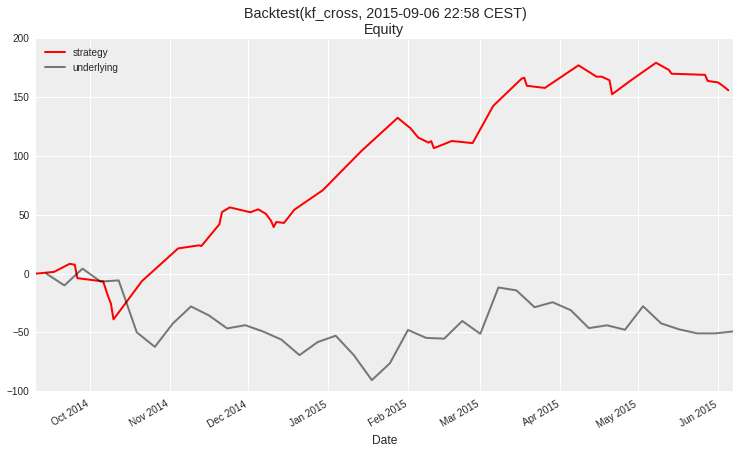

In [69]:
figsize(12.5, 7)
bt_kf.plot_equity()

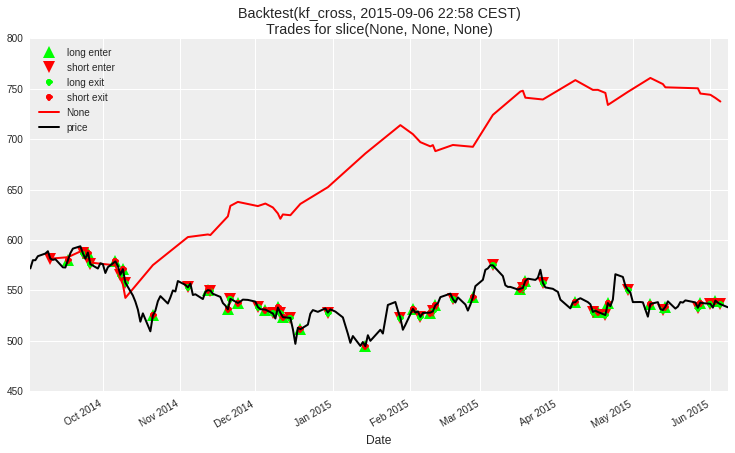

In [101]:
figsize(12.5, 7)
bt_kf.plot_trades()
legend(loc='upper left')

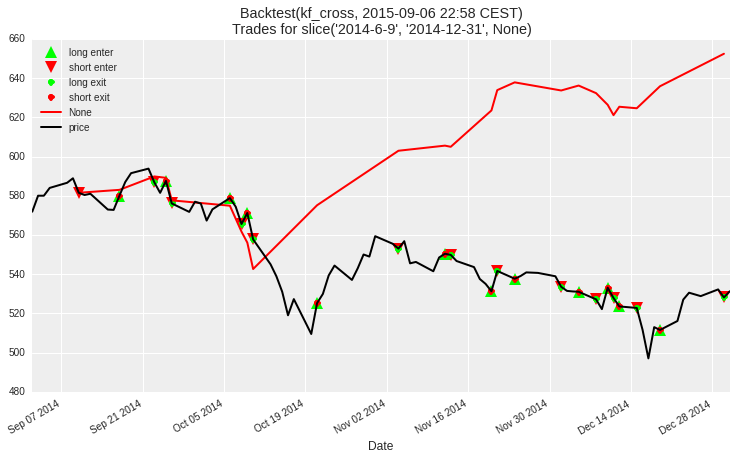

In [102]:
# the main equity is earned in the second half of the last year
bt_kf.trdplot['2014-6-9':'2014-12-31']
legend(loc='upper left')


It looks promising! At least, our strategy returns the 155.9276 of profit in comparison with the underlying
strategy, i.e. the opened long (buy) position for the whole period. Also,looking at the plots, we can conclude that 
the strategy requires the optimization:

* we need to catch the transformation from  non-stationary to non-stationary processes. In the latter case, we have 
to close all open positions.

* Such tool to deal with the non-stationary process is ARMA model, which will be discussed later.

Now we can introduce the crossing SMA strategy:

In [108]:

# we need to increase the period of analysis
ohlc = pybacktest.load_from_yahoo('GOOG',start= "2011")
ohlc

,O,H,L,C,V,AC
Date,,,,,,
2014-03-27,568.00257,568.00257,552.92252,558.46255,13100,558.46255
2014-03-28,561.20255,566.43259,558.67248,559.99250,41200,559.99250
2014-03-31,566.89259,567.00257,556.93254,556.97250,10800,556.97250
2014-04-01,558.71257,568.45260,558.71257,567.16256,7900,567.16256
2014-04-02,599.99271,604.83276,562.19257,567.00257,147100,567.00257
2014-04-03,569.85255,587.28268,564.13258,569.74257,5099200,569.74257
2014-04-04,574.65264,577.77265,543.00249,543.14246,6369300,543.14246
2014-04-07,540.74245,548.48248,527.15244,538.15246,4401700,538.15246
2014-04-08,542.60247,555.00250,541.61245,554.90256,3151200,554.90256


In [113]:


short_ma =10 # 
long_ma = 50 #

ms = pd.rolling_mean(ohlc.C, short_ma)
ml = pd.rolling_mean(ohlc.C, long_ma)
    
buy = cover = (ms > ml) & (ms.shift() < ml.shift())  # ma cross up
sell = short = (ms < ml) & (ms.shift() > ml.shift())  # ma cross down

print '>  Short MA\n%s\n' % ms.tail()
print '>  Long MA\n%s\n' % ml.tail()
print '>  Buy/Cover signals\n%s\n' % buy.tail()
print '>  Short/Sell signals\n%s\n' % sell.tail()

bt = pybacktest.Backtest(locals(), 'ma_cross')
print filter(lambda x: not x.startswith('_'), dir(bt))
print '\n>  bt.signals\n%s' % bt.signals.tail()
print '\n>  bt.trades\n%s' % bt.trades.tail()
print '\n>  bt.positions\n%s' % bt.positions.tail()
print '\n>  bt.equity\n%s' % bt.equity.tail()
print '\n>  bt.trade_price\n%s' % bt.trade_price.tail()



>  Short MA
Date
2015-06-02    537.642000
2015-06-03    537.937001
2015-06-04    537.680000
2015-06-05    536.762001
2015-06-08    535.434004
dtype: float64

>  Long MA
Date
2015-06-02    540.395883
2015-06-03    540.025833
2015-06-04    539.355981
2015-06-05    538.846832
2015-06-08    538.279982
dtype: float64

>  Buy/Cover signals
Date
2015-06-02    False
2015-06-03    False
2015-06-04    False
2015-06-05    False
2015-06-08    False
dtype: bool

>  Short/Sell signals
Date
2015-06-02    False
2015-06-03    False
2015-06-04    False
2015-06-05    False
2015-06-08    False
dtype: bool

['dataobj', 'default_price', 'eqplot', 'equity', 'name', 'ohlc', 'plot_equity', 'plot_trades', 'positions', 'prices', 'report', 'run_time', 'signals', 'sigplot', 'stats', 'summary', 'trade_price', 'trades', 'trdplot']

>  bt.signals
              Buy  Cover   Sell  Short
Date                                  
2015-06-02  False  False  False  False
2015-06-03  False  False  False  False
2015-06-04  False

In [114]:
bt.summary()

-----------------------------------------------
|  Backtest(ma_cross, 2015-10-06 00:06 CEST)  |
----------------------------------------------- 

backtest:
  days: !!python/long '230'
  from: '2014-08-22 00:00:00'
  to: '2015-04-09 00:00:00'
  trades: 6
exposure:
  trades/month: 1.2
performance:
  PF: 2.7668
  RF: 6.0029
  averages:
    gain: 31.9152
    loss: -5.7676
    trade: 6.7933
  payoff: 5.5336
  profit: 40.7601
  winrate: 0.3333
risk/return profile:
  MPI: 2.2316
  UPI: 1.8597
  WCDD (monte-carlo 0.99 quantile): 23.0702
  maxdd: 6.7901
  sharpe: 0.2893
  sortino: 0.9585

-----------------------------------------------


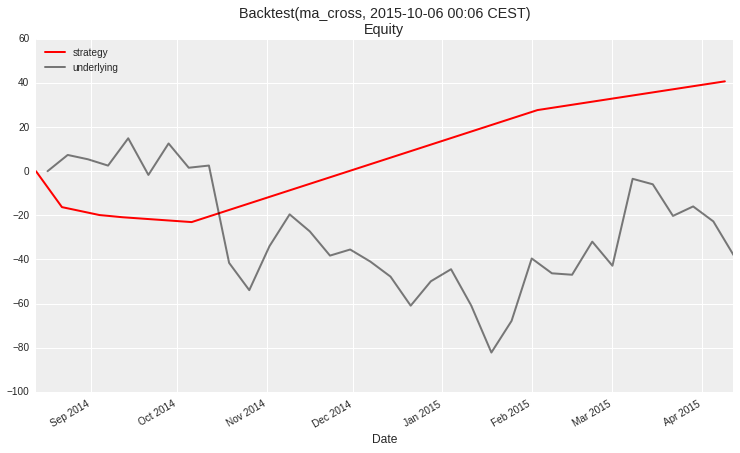

In [115]:
figsize(12.5, 7)
bt.plot_equity()
legend(loc='upper left')

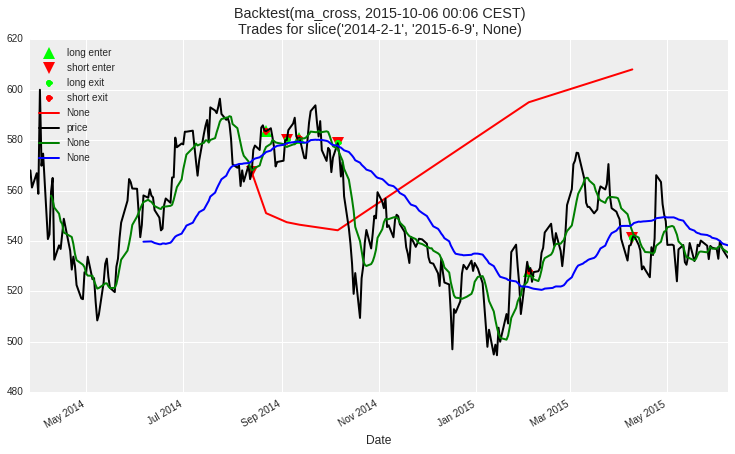

In [117]:
# the main equity is earned in the last few months
bt.trdplot['2014-2-1':'2015-6-9']
pd.rolling_mean(ohlc.C['2014-2-1':'2015-6-9'], short_ma).plot(c='green')
pd.rolling_mean(ohlc.C['2014-2-1':'2015-6-9'], long_ma).plot(c='blue')
legend(loc='upper left')

The strategy based on crossed SMA doesn't work at all. The reason of this is the too short period used in this analysis.
As a result, too small short SMA and long SMA (reduce in 2.5 and 4 times accordingly).


References
-------------------

-------------------




Hoffman & Gelman. (2011). [The No-U-Turn Sampler: Adaptively Setting Path Lengths in Hamiltonian Monte Carlo.](http://arxiv.org/abs/1111.4246)